In [18]:
import os
import pandas as pd
import numpy as np
import pickle
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
PUSHSHIFT_OUTPUT_DIR = 'pushshift_output'
PRAW_OUTPUT_DIR = 'praw_output'
POSTS_DIR = 'posts'
COMMENTS_DIR = 'post_comments'

# Posts

Gathering all the Pushshift and PRAW output and dropping duplicate posts, we have 1.27M posts total.

In [3]:
pushshift_dfs = [pd.read_pickle(f) for f in glob.glob(os.path.join(PUSHSHIFT_OUTPUT_DIR,POSTS_DIR,'*','*.pkl'))]
pushshift_dfs = [x for x in pushshift_dfs if len(x) > 0]
all_pushshift_posts = pd.concat(pushshift_dfs,axis=0)
unique_pushshift_posts = all_pushshift_posts.drop_duplicates('id',keep='first')

praw_dfs = [pd.read_csv(f,sep='\t',header=0) for f in glob.glob(os.path.join(PRAW_OUTPUT_DIR,POSTS_DIR,'*.tsv'))]
all_praw_posts = pd.concat(praw_dfs,axis=0)
unique_praw_posts = all_praw_posts.drop_duplicates('id',keep='first')

print('Number of unique Pushshift posts, PRAW posts: {}, {}'.format(len(unique_pushshift_posts),
                                                                    len(unique_praw_posts)))

print('Fields from PRAW that are missing from Pushshift:',[x for x in all_praw_posts.columns if x not in 
                                                          unique_pushshift_posts.columns])
      
all_posts = pd.concat([unique_pushshift_posts,unique_praw_posts],axis=0)
unique_posts = all_posts.drop_duplicates('id',keep='first')
print('Number of unique posts, combining Pushshift and PRAW:',len(unique_posts))

Number of unique Pushshift posts, PRAW posts: 1382615, 31569
Fields from PRAW that are missing from Pushshift: ['num_downs', 'num_ups']
Number of unique posts, combining Pushshift and PRAW: 1409520


In [77]:
unique_posts.columns

Index(['id', 'title', 'url', 'author', 'score', 'date', 'num_comments',
       'permalink', 'flair', 'is_video', 'upvote_ratio', 'text', 'subreddit',
       'num_downs', 'num_ups'],
      dtype='object')

Drop posts without text--no point keeping them.

In [272]:
unique_posts.title.apply(lambda x: type(x)).value_counts()

<class 'str'>         976789
<class 'NoneType'>    432731
Name: title, dtype: int64

In [276]:
unique_posts.loc[(unique_posts.title.apply(lambda x: isinstance(x,str)))].shape

(976789, 19)

In [273]:
unique_posts.text.apply(lambda x: type(x)).value_counts()

<class 'str'>      1388517
<class 'float'>      21003
Name: text, dtype: int64

In [277]:
unique_posts.loc[(unique_posts.text.apply(lambda x: isinstance(x,str)))].shape

(1388517, 19)

In [4]:
posts_with_text = unique_posts.loc[(unique_posts.title.apply(lambda x: isinstance(x,str))) |
                                           (unique_posts.text.apply(lambda x: isinstance(x,str)))].copy()
posts_with_text.shape

(1409520, 15)

In [27]:
# Add column for parsed date
posts_with_text['parsed_date'] = posts_with_text.date.apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isnull(x)
                                                     and type(x) == float else x)
# Extract month, year
posts_with_text['year'] = posts_with_text.parsed_date.apply(lambda x: x.year if not pd.isnull(x)
                                                     else None)
posts_with_text['month'] = posts_with_text.parsed_date.apply(lambda x: x.month if not pd.isnull(x)
                                                     else None)

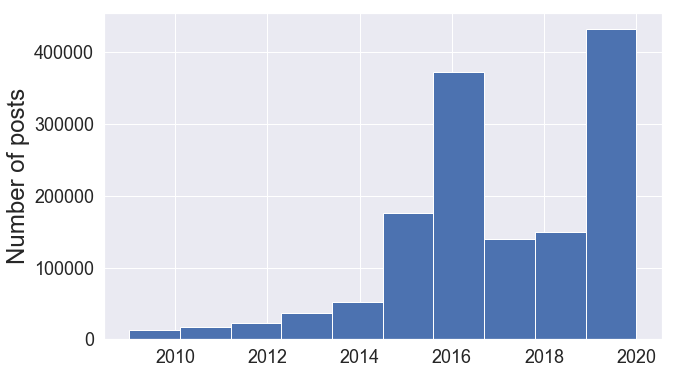

In [28]:
ax = posts_with_text['year'].plot.hist(figsize=(10,6))
ax.set_ylabel("Number of posts",fontsize=24)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

In [229]:
#unique_posts['month'].plot.hist()

In [232]:
#list(unique_posts.flair.value_counts().index)

There are 2.5k video posts:

In [233]:
unique_posts.is_video.value_counts()

False    689785
True       2544
Name: is_video, dtype: int64

There are 1.4M posts that have some form of text, in either the title or body.

In [278]:
posts_with_text.shape

(1409520, 19)

But which of these have non-zero num words?

In [280]:
posts_with_text['title_num_words'] = posts_with_text.title.apply(lambda x: len(x.split()) if x is not None else 0)

In [282]:
posts_with_text['body_num_words'] = posts_with_text.text.apply(lambda x: len(x.split()) if not isinstance(x,float)
                                                               else 0)

So 977k posts have title w/ non-zero words; 236k have body w/ non-zero words. 

In [283]:
print(posts_with_text.loc[posts_with_text['title_num_words'] > 0].shape,
      posts_with_text.loc[posts_with_text['body_num_words'] > 0].shape)

(976789, 20) (235526, 20)


Combined, there are 977k posts with >0 num words in either title or body.

In [288]:
posts_with_text.loc[(posts_with_text.title_num_words > 0) |
                   (posts_with_text.body_num_words > 0)].shape

(976789, 20)

In [290]:
posts_with_text['total_num_words'] = posts_with_text['title_num_words'] + posts_with_text['body_num_words']

Let's plot the number of words in title/body:

In [296]:
# ax = posts_with_text['title_num_words'].loc[posts_with_text['title_num_words'] > 0].plot.hist(bins=50,figsize=(10,6))
# ax.set_xlabel("Number of words in title",fontsize=24)
# ax.set_ylabel("Number of posts",fontsize=24)
# ax.tick_params(axis="x",labelsize=20)
# ax.tick_params(axis="y",labelsize=20)

In [295]:
# ax = posts_with_text.loc[posts_with_text['body_num_words'] > 0]['body_num_words'].plot.hist(bins=50,figsize=(10,6))
# ax.set_xlabel("Number of words in body",fontsize=24)
# ax.set_ylabel("Number of posts",fontsize=24)
# ax.tick_params(axis="x",labelsize=20)
# ax.tick_params(axis="y",labelsize=20)

In [ ]:
# Combined
# ax = posts_with_text.loc[(posts_with_text['total_num_words'] > 0) &
#                          (posts_with_text['total_num_words'] < 100)]['total_num_words'].plot.hist(bins=50,figsize=(10,6))
# ax.set_xlabel("Number of words in body and title",fontsize=24)
# ax.set_ylabel("Number of posts",fontsize=24)
# ax.tick_params(axis="x",labelsize=20)
# ax.tick_params(axis="y",labelsize=20)

All posts have a score; only 62k have an upvote ratio. Oddly, the posts with a non-null number of comments (incl. 0) seem to be the same as those with some kind of title or body text?

In [297]:
# datapoints with X
posts_with_text.loc[(posts_with_text['total_num_words'] > 0)].shape

(976789, 21)

In [298]:
print(posts_with_text.loc[~pd.isnull(posts_with_text.score)].shape,
posts_with_text.loc[~pd.isnull(posts_with_text.num_comments)].shape,
posts_with_text.loc[~pd.isnull(posts_with_text.upvote_ratio)].shape)

(1409519, 21) (976788, 21) (61712, 21)


Number of posts with both non-zero word count and upvote ratio is the same as number of posts with upvote ratio:

In [299]:
posts_with_text.loc[(~pd.isnull(posts_with_text.upvote_ratio)) & 
                          (posts_with_text['total_num_words'] > 0)].shape

(61712, 21)

Number of posts with both text and score is the same as number of posts with text, since all posts have a score.

In [300]:
posts_with_text.loc[(~pd.isnull(posts_with_text.score)) & 
                          (posts_with_text['total_num_words'] > 0)].shape

(976788, 21)

We want both text and an outcome for using Reid's model. We can use either the title text, or title text and body text, as X and have the same size of X.

* X = text (title, or both title and body), N = 976,789
* Y = upvote ratio, N = 61,712
* Y = score, N = 976,788

(Do any of the texted posts represent videos?) They all do!

In [115]:
unique_posts.loc[(unique_posts.is_video) & 
                          (unique_posts.title.apply(lambda x: len(x) > 0 
                                                             if x is not None else False))].shape

(2544, 15)

We also want some variables to control for using Reid's model. Let's examine which of these are missing from the potential X, Y: author, date, is_video, subreddit.

In [301]:
print(
    posts_with_text.loc[~pd.isnull(posts_with_text.author)].shape,
    posts_with_text.loc[~pd.isnull(posts_with_text.date)].shape,
    posts_with_text.loc[~pd.isnull(posts_with_text.is_video)].shape,
    posts_with_text.loc[~pd.isnull(posts_with_text.subreddit)].shape
)

(1409302, 21) (1409519, 21) (692329, 21) (1409310, 21)


Other than whether or not a post is a video, most posts have all 4 attributes.

Let's examine the distribution of scores, upvote_ratio.

In [387]:
posts_with_upvr = posts_with_text.loc[(~pd.isnull(posts_with_text.upvote_ratio)) & 
                          (posts_with_text['total_num_words'] > 0)]

In [ ]:
# log_upvr = pd.Series(posts_with_upvr.upvote_ratio+0.001).apply(lambda x: np.log(x))
# ax = posts_with_upvr.upvote_ratio.plot.hist(bins=10,figsize=(10,6)) 
# ax.set_ylabel("Number of posts",fontsize=24)
# ax.set_xlabel("Log upvote ratio",fontsize=24)
# ax.tick_params(axis='x',labelsize=20)
# ax.tick_params(axis='y',labelsize=20)

In [ ]:
# fig,ax = plt.subplots(figsize=(10,6))
# ax.hist(np.log(posts_with_text.loc[(~pd.isnull(posts_with_text.score)) & 
#                           (posts_with_text['total_num_words'] > 0)].score+0.001),
# bins=np.log([1, 2, 5, 10, 25, 75, 200]),histtype='bar')#,ax=ax)
# ax.set_xlabel("Log post score",fontsize=24)
# ax.set_ylabel("Number of posts",fontsize=24)
# ax.tick_params(axis='x',labelsize=20)
# ax.tick_params(axis='y',labelsize=20)

We have representation from 32k subreddits and 391k users.

In [243]:
print(len(unique_posts.loc[~pd.isnull(unique_posts.subreddit)].subreddit.value_counts()),
      len(unique_posts.loc[~pd.isnull(unique_posts.author)].author.value_counts()))

34272 424697


In [302]:
print(len(posts_with_text.loc[~pd.isnull(posts_with_text.subreddit)].subreddit.value_counts()),
      len(posts_with_text.loc[~pd.isnull(posts_with_text.author)].author.value_counts()))

34272 424697


Distribution of posts written by users.

In [29]:
nan_authors = set(['[deleted]','-1',-1,'-en-'])

In [30]:
posts_with_authors = posts_with_text.loc[~posts_with_text.author.isin(nan_authors)]

In [31]:
posts_with_authors.author.value_counts()#.index)

EcoInternetNewsfeed    58008
itchyyyyscrotum        30784
AutoNewsAdmin          22312
BirdieBroBot           21947
AutoNewspaperAdmin     21035
                       ...  
greenewit1234              1
Langly-                    1
Pyrophagist                1
Willowmound                1
RustyRickets               1
Name: author, Length: 424693, dtype: int64

In [306]:
posts_with_authors.author.value_counts().apply(lambda x: np.log(x))

EcoInternetNewsfeed    10.968336
itchyyyyscrotum        10.334750
AutoNewsAdmin          10.012880
BirdieBroBot            9.996386
AutoNewspaperAdmin      9.953943
                         ...    
drsloth1138             0.000000
Tack_Tau                0.000000
PunishedKvetch          0.000000
basenaijanews           0.000000
Slanglie                0.000000
Name: author, Length: 424693, dtype: float64

In [33]:
posts_per_author = posts_with_authors.author.value_counts()

In [247]:
print('Number of authors with 100 or fewer posts:',
      len([a for a in posts_per_author if posts_per_author[a] <= 100]))
print('Number of authors with b/w 100 to 1000 posts:',
      len([a for a in posts_per_author if posts_per_author[a] <= 1000 and posts_per_author[a] > 100]))
print('Number of authors with b/w 1000 to 5000 posts:',
      len([a for a in posts_per_author if posts_per_author[a] <= 5000 and posts_per_author[a] > 1000]))
print('Number of authors with b/w 5000 to 10000 posts:',
      len([a for a in posts_per_author if posts_per_author[a] <= 10000 and posts_per_author[a] > 5000]))
print('Number of authors with more than 10,000 posts:',
      len([a for a in posts_per_author if posts_per_author[a] > 10000]))

Number of authors with 100 or fewer posts: 424034
Number of authors with b/w 100 to 1000 posts: 608
Number of authors with b/w 1000 to 5000 posts: 39
Number of authors with b/w 5000 to 10000 posts: 6
Number of authors with more than 10,000 posts: 6


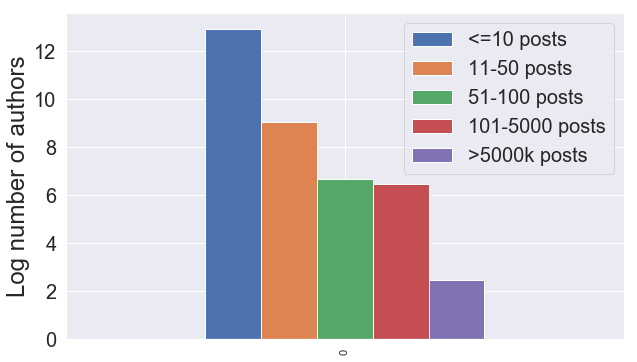

In [34]:
df_ = pd.DataFrame({
    '<=10 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 10])),
    '11-50 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 50 and 
                             posts_per_author[a] > 10])),
    '51-100 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 100 and 
                             posts_per_author[a] > 50])),
    '101-5000 posts':np.log(len([a for a in posts_per_author.index if posts_per_author[a] <= 5000 and 
                               posts_per_author[a] > 100])),
    '>5000k posts':np.log(len([a for a in posts_per_author.index if  
                               posts_per_author[a] > 5000]))
},index=[0])
ax = df_.plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Log number of authors",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

In [35]:
len([a for a in posts_per_author.index if posts_per_author[a] <= 10])

414745

Distribution of subreddits posted in by users.

In [264]:
df_a = posts_with_authors.drop_duplicates(['author', 'subreddit'])
df_a.groupby('author').size()

author
--------__--------       2
------_-_-_-_-_          1
------_________          1
------w                  1
-----BroAway-----        1
                        ..
zzzzz1233                1
zzzzz94                 11
zzzzzzp                  1
zzzzzzzxxxxxxxxx         1
zzzzzzzzzzzzzzzzspaf     3
Length: 424693, dtype: int64

In [265]:
subreddits_per_author = df_a.groupby('author').size()

In [266]:
subreddits_per_author['zzzzz94']

11

In [267]:
print('Number of authors posting in <100 subreddits:',
      len([a for a in subreddits_per_author if subreddits_per_author[a] <= 100]))
print('Number of authors posting in 100 to 1000 subreddits:',
      len([a for a in subreddits_per_author if subreddits_per_author[a] <= 1000 and subreddits_per_author[a] > 100]))
print('Number of authors posting in 1000 to 5000 subreddits:',
      len([a for a in subreddits_per_author if subreddits_per_author[a] <= 5000 and subreddits_per_author[a] > 1000]))
print('Number of authors posting in 5000 to 10000 subreddits:',
      len([a for a in subreddits_per_author if subreddits_per_author[a] <= 10000 and subreddits_per_author[a] > 5000]))
print('Number of authors posting in >10,000 subreddits:',
      len([a for a in subreddits_per_author if subreddits_per_author[a] > 10000]))

Number of authors posting in <100 subreddits: 424680
Number of authors posting in 100 to 1000 subreddits: 13
Number of authors posting in 1000 to 5000 subreddits: 0
Number of authors posting in 5000 to 10000 subreddits: 0
Number of authors posting in >10,000 subreddits: 0


In [ ]:
df_ = pd.DataFrame({
    '<=10 subreddits':np.log(len([a for a in subreddits_per_author.index if subreddits_per_author[a] <= 10])),
    '11-50 subreddits':np.log(len([a for a in subreddits_per_author.index if subreddits_per_author[a] <= 50 and 
                             subreddits_per_author[a] > 10])),
    '51-100 subreddits':np.log(len([a for a in subreddits_per_author.index if subreddits_per_author[a] <= 100 and 
                             subreddits_per_author[a] > 50])),
    '101-1000 subreddits':np.log(len([a for a in subreddits_per_author.index if subreddits_per_author[a] <= 1000 and 
                               subreddits_per_author[a] > 100]))
},index=[0])
ax = df_.plot.bar(figsize=(10,6))
ax.set_xlabel("")
ax.set_ylabel("Log number of authors",fontsize=24)
ax.tick_params(axis="y",labelsize=20)
plt.legend(fontsize=20)

Number of comments generated by a post:

In [5]:
comments_per_post = posts_with_text.loc[~pd.isnull(posts_with_text.num_comments)].num_comments.value_counts()

In [20]:
# Unique commenters only
# Drop duplicate authors
unique_auth_comments_per_post = posts_with_text.loc[~pd.isnull(posts_with_text.num_comments)].drop_duplicates('author',keep='first').\
num_comments.value_counts()

In [21]:
# ax = pd.DataFrame({
#     '0 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n == 0.0]),
#     '1-10 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n > 0.0 and n <= 10.0]),
#     '11-100 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n > 10.0 and n <= 100.0]),
#     '>100 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n > 100.0])
# },index=[0]).plot.bar(figsize=(10,6))
# ax.set_xlabel("")
# ax.set_ylabel("Number of posts",fontsize=24)
# ax.tick_params(axis="y",labelsize=20)
# plt.legend(fontsize=20)

In [24]:
#Unique commenters only
# ax = pd.DataFrame({
#     '0 comments':np.sum([comments_per_post[n] for n in comments_per_post.index if n == 0.0]),
#     '1-10 comments':np.sum([unique_auth_comments_per_post[n] for n in unique_auth_comments_per_post.index if n > 0.0 and n <= 10.0]),
#     '11-100 comments':np.sum([unique_auth_comments_per_post[n] for n in unique_auth_comments_per_post.index if n > 10.0 and n <= 100.0]),
#     '>100 comments':np.sum([unique_auth_comments_per_post[n] for n in unique_auth_comments_per_post.index if n > 100.0])
# },index=[0]).plot.bar(figsize=(10,6))
# ax.set_xlabel("")
# ax.set_ylabel("Number of posts",fontsize=24)
# ax.tick_params(axis="y",labelsize=20)
# plt.legend(fontsize=20)

In [326]:
print('Number of posts w/ 0 comments:',
      np.sum([comments_per_post[n] for n in comments_per_post if n == 0.0]))
print('Number of posts w/ >0, <= 100 comments',
      np.sum([comments_per_post[n] for n in comments_per_post if n > 0.0 and n <= 100.0]))
print('Number of posts w/ >100, <= 500 comments:',
      np.sum([comments_per_post[n] for n in comments_per_post if n > 100.0 and n <= 500.0]))
print('Number of posts w/ >500, <= 1,000 comments:',
      np.sum([comments_per_post[n] for n in comments_per_post if n > 500.0 and n <= 1000.0]))
print('Number of posts w/ >1k comments:',
      np.sum([comments_per_post[n] for n in comments_per_post if n > 1000.0]))

Number of posts w/ 0 comments: 535762
Number of posts w/ >0, <= 100 comments 429543
Number of posts w/ >100, <= 500 comments: 9360
Number of posts w/ >500, <= 1,000 comments: 1121
Number of posts w/ >1k comments: 1002


# Comments

We have 3.6M unique comments, combining Pushshift and PRAW.

In [414]:
pushshift_dfs = [pd.read_pickle(f) for f in glob.glob(os.path.join(PUSHSHIFT_OUTPUT_DIR,COMMENTS_DIR,'*','*.pkl'))]
pushshift_dfs = [x for x in pushshift_dfs if len(x) > 0]
all_pushshift_comments = pd.concat(pushshift_dfs,axis=0)
unique_pushshift_comments = all_pushshift_comments.drop_duplicates('id',keep='first')

praw_dfs = [pd.read_csv(f,sep='\t',header=0) for f in glob.glob(os.path.join(PRAW_OUTPUT_DIR,COMMENTS_DIR,'*.tsv'))]
all_praw_comments = pd.concat(praw_dfs,axis=0)
unique_praw_comments = all_praw_comments.drop_duplicates('id',keep='first')

print('Number of unique Pushshift, PRAW comments: {}, {}'.format(len(unique_pushshift_comments),
                                                                    len(unique_praw_comments)))

print('Fields from PRAW that are missing from Pushshift:',[x for x in all_praw_comments.columns if x not in 
                                                          unique_pushshift_comments.columns])
      
all_comments = pd.concat([unique_pushshift_comments,unique_praw_comments],axis=0)
unique_comments = all_comments.drop_duplicates('id',keep='first')
print('Number of unique comments, combining Pushshift and PRAW:',len(unique_comments))

Number of unique Pushshift, PRAW comments: 8119184, 370
Fields from PRAW that are missing from Pushshift: ['submission_id', 'controversiality', 'num_downs', 'num_ups', 'num_likes']


KeyboardInterrupt: 

In [ ]:
# Drop comments without text or missing other fields

comments_with_text = unique_comments.loc[(unique_comments.text.apply(lambda x: isinstance(x,str)))].copy()
print('Dropping comments without text, new shape:',comment_with_text.shape)

# comments_with_text['num_words'] = comments_with_text['text'].apply(lambda x: len(x.split()))
# comments_with_words = comments_with_text.loc[comments_with_text['num_words'] > 0]
# print('Dropping comments with 0 words, new shape:',comment_with_words.shape)

# comments_with_words_complete = comments_with_words.loc[~pd.isnull(comments_with_words.date) &
#                                                       ~pd.isnull(comments_with_words.subreddit) &
#                                                       ~pd.isnull(comments_with_words.score) &
#                                                       ~pd.isnull(comments_with_words.author)]

In [ ]:
unique_comments.text.apply(lambda x: type(x)).value_counts()

In [ ]:
comments_with_words_complete.author.value_counts()

In [ ]:
comments_with_words_authors_complete = comments_with_words_complete.loc[
    ~comments_with_words_complete.author.isin(bad_authors)]
print('Dropping comments with bad authors, new shape:',comments_with_words_authors_complete.shape)

In [ ]:
bad_authors = set(['[deleted]','-1',-1])

In [137]:
unique_comments.columns 

Index(['id', 'author', 'score', 'date', 'permalink', 'text', 'subreddit',
       'submission_id', 'controversiality', 'num_downs', 'num_ups',
       'num_likes'],
      dtype='object')

In [151]:
# unique_comments['parsed_date'] = unique_comments.date.apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isnull(x)
#                                                      and type(x) == float else x)
# # Extract month, year
# unique_comments['year'] = unique_comments.parsed_date.apply(lambda x: x.year if not 
#                                                            pd.isnull(x) else None)
# unique_comments['month'] = unique_comments.parsed_date.apply(lambda x: x.month if not 
#                                                            pd.isnull(x) else None)

## Explore distribution of each attribute 

In [146]:
## Time

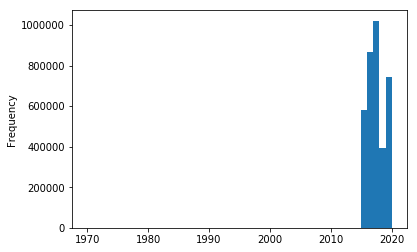

In [144]:
unique_comments['year'].plot.hist(bins=50)

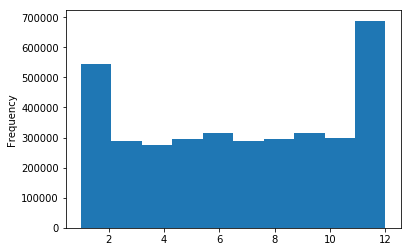

In [145]:
unique_comments['month'].plot.hist()

Main X, Y for model (text and engagement signals):

All 3.6M comments have text.

In [149]:
unique_comments.loc[(unique_comments.text.apply(lambda x: len(x) > 0))].shape

(3605917, 15)

Number of words in comments, where "words" are just split on whitespace:

In [153]:
unique_comments['num_words'] = unique_comments.text.apply(lambda x: len(x.split()))#.hist()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Distribution of #words in comments: 

In [ ]:
ax = comments_with_words_authors_complete.loc[
                         (comments_with_words_authors_complete['num_words'] < 500)]['num_words'].plot.hist(bins=50,figsize=(10,6))
ax.set_xlabel("Number of words in comment",fontsize=24)
ax.set_ylabel("Number of comments",fontsize=24)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

Most comments only have score as an engagement metric:

In [164]:
print(unique_comments.loc[~pd.isnull(unique_comments.score)].shape,
unique_comments.loc[~pd.isnull(unique_comments.controversiality)].shape,
unique_comments.loc[~pd.isnull(unique_comments.num_ups)].shape,
     unique_comments.loc[~pd.isnull(unique_comments.num_downs)].shape,
     unique_comments.loc[~pd.isnull(unique_comments.num_likes)].shape)

(3605891, 16) (360, 16) (360, 16) (359, 16) (1, 16)


The distribution of comment scores is

In [ ]:
unique_comments.loc[~pd.isnull(unique_comments.score)].score.plot.boxplot()

We want both text and an outcome for using Reid's model. We are constrained only by the size of Y if we use something other than score as Y. All datapoints have X, the text.

* X = text, N = 3,605,917
* Y = score, N = 3,605,891
* Y = not score, N = 360

What variables can we control for? Basically all of author, date, and subreddit.

In [174]:
print(
    unique_comments.loc[~pd.isnull(unique_comments.author)].shape,
    unique_comments.loc[~pd.isnull(unique_comments.date)].shape,
    unique_comments.loc[~pd.isnull(unique_comments.subreddit)].shape
)

(3605917, 16) (3605916, 16) (3605915, 16)


We have representation from 26k subreddits and 1M users.

In [176]:
print(len(unique_comments.loc[~pd.isnull(unique_comments.subreddit)].subreddit.value_counts()),
      len(unique_comments.loc[~pd.isnull(unique_comments.author)].author.value_counts()))

26084 1005399


# Posts and comments

Combining posts and comments, we have 44k unique subreddits and 1M unique users.

In [180]:
print(len(set(unique_comments.subreddit) | set(unique_posts.subreddit)),
      len(set(unique_comments.author) | set(unique_posts.author)))

43966 1148762


In [182]:
len(unique_comments)

3605917

In [183]:
len(unique_posts)

1271538

Most common subreddits:

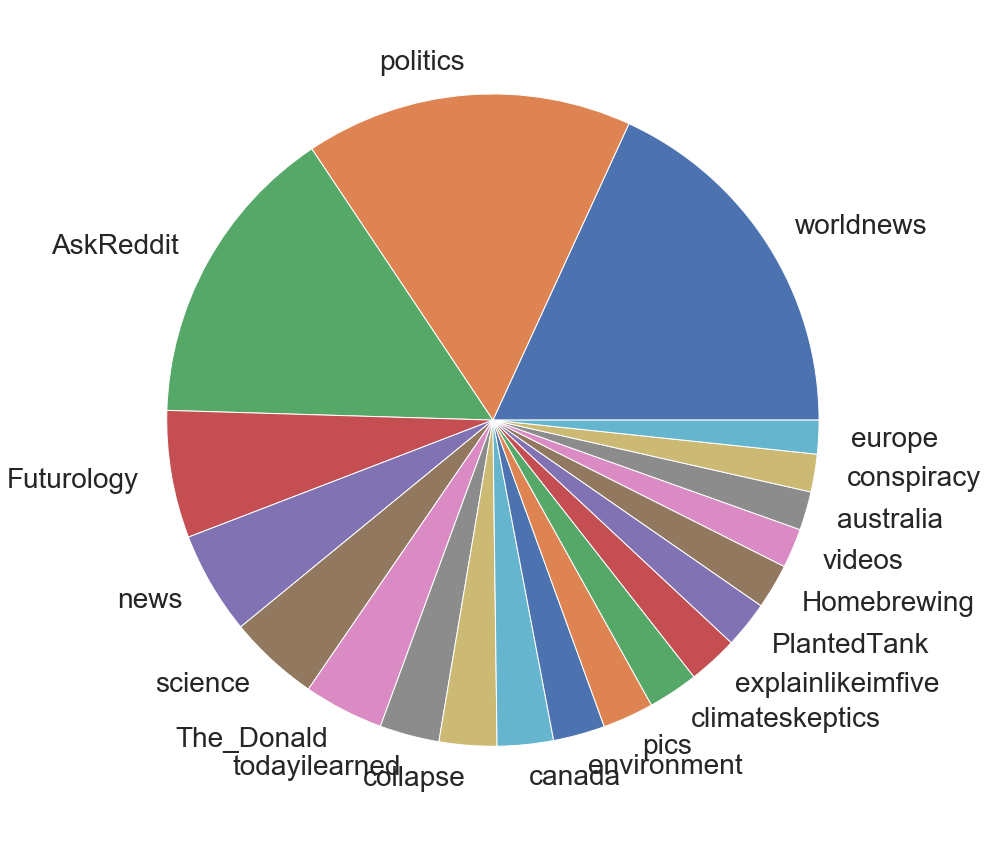

In [413]:
unique_comments['subreddit'].value_counts()[:20].plot.pie(figsize=(15, 15),label='',textprops={'fontsize': 28})

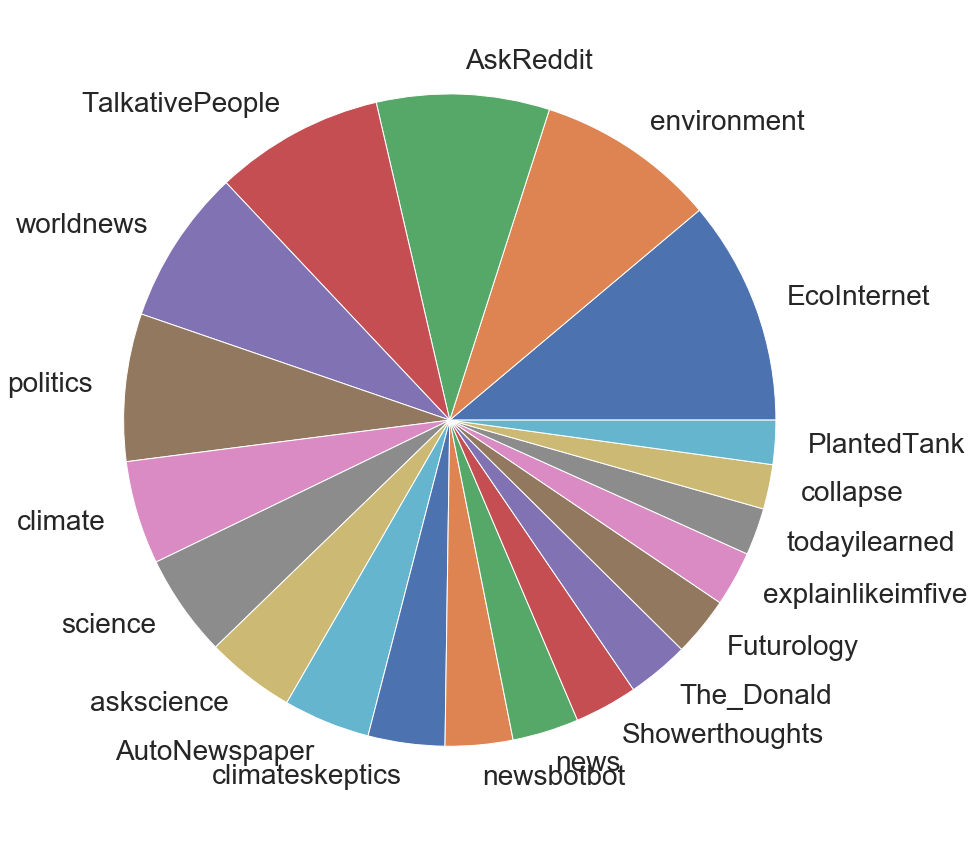

In [412]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20.0
ax = unique_posts['subreddit'].value_counts()[:20].plot.pie(figsize=(15, 15),label='',
                                                           textprops={'fontsize': 28})

# Old

Distribution of comments from different authors:

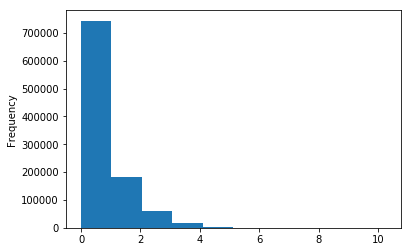

In [177]:
# Log. #comments written
unique_comments.loc[~pd.isnull(unique_comments.author)].author.value_counts().apply(lambda x: np.log(x)).plot.hist()

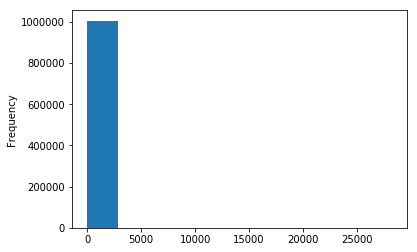

In [178]:
# Raw #comments written
unique_comments.loc[~pd.isnull(unique_comments.author)].author.value_counts().plot.hist()

In [40]:
print('Distribution over controversiality of comments:')
all_comments_df.controversiality.value_counts()

Distribution over controversiality of comments:


0.0    364
1.0      5
Name: controversiality, dtype: int64

In [44]:
# Examine most controversial comments
list(all_comments_df.loc[all_comments_df.controversiality == 1.0].text)

['These have all been covered at the daily briefings.  Have you watched them?    Not sure what else can be done.    As far as the past goes, yes, H1N1 wiped out the supplies, those need refreshed.',
 "And the WHO was telling the world it wasn't contagious at that point. Meanwhile GEOTUS formed the task force and shut down travel from China, for which Dems attacked him.",
 'c0gpcim',
 "If you ask a medical professional how best to prevent the spread of the virus, an economist how best to protect peoples livelihoods, and a mental health professional the best way of protecting people's sanity...you're going to end up with some very conflicting policy.Politicians have to draw it all together and make it work. Spoilers: you can't.",
 "Because global warming has been turned into a focal point of contrarians. The word itself has been tainted, and just because it's cold out doesn't mean that global warming isn't still a huge problem."]

In [49]:
# Small bug in comment ids affecting 3 comments (does not seem consequential for now)
all_comments_df.id.apply(lambda x: type(x)).value_counts()

<class 'str'>      368
<class 'float'>      3
Name: id, dtype: int64

In [50]:
all_comments_df.loc[all_comments_df.id.apply(lambda x: type(x) == float)]

,submission_id,author,text,date,id,controversiality,num_downs,num_ups,num_likes,score,subreddit,parsed_date,year,month
0,ab3wt,heystoopid,|[Total BS](http://www.wunderground.com/blog/J...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,[And crock of the week too !](http://climatepr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,[A word from a supreme authority on this issue...,1259988777.0,c0gpcim,0.0,0,1.0,NaN,1.0,climategate,NaN,NaN,1970-01-01,1970.0,1.0


In [51]:
# But affects a lot more posts--not sure if they're truly NaNs or not
all_posts_df.id.apply(lambda x: type(x)).value_counts()

<class 'str'>      31568
<class 'float'>      733
Name: id, dtype: int64

In [52]:
all_posts_df.loc[all_posts_df.id.apply(lambda x: type(x) == float)]

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
30,|IT’S TIME TO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
31,CONNECT THE DOTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
34,|INSERT ___________ HERE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
470,Started to school strike for climate change ou...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
471,Greta Thunberg started the global movement Fri...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,|Effect of Record Drought on Amazon Studied -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
914,|Peru's arid capital in serious danger of runn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
918,|Scientists study record-breaking 2010 heatwave -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
953,|China's weather forecasters reluctant to conf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


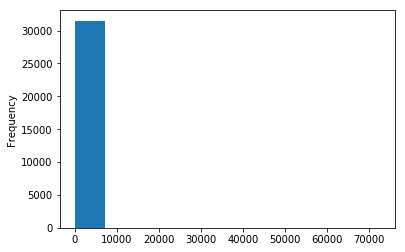

In [57]:
all_posts_df.num_ups.plot.hist(bins=10)

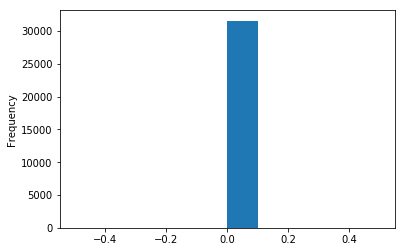

In [58]:
all_posts_df.num_downs.plot.hist(bins=10)

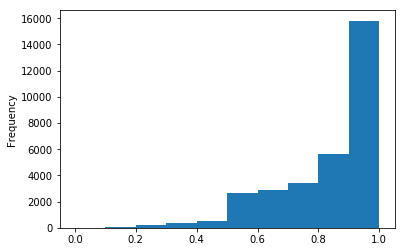

In [60]:
# Better signal that num_ups/num_downs--probably best available signal
all_posts_df.upvote_ratio.plot.hist(bins=10) 

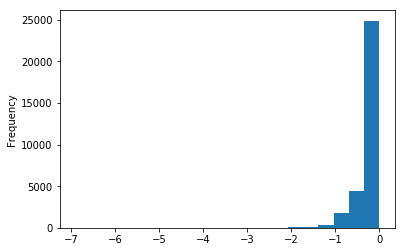

In [24]:
# Log upvote ratio:
all_posts_df.upvote_ratio.apply(lambda x: np.log(x+0.001)).plot.hist(bins=20) 

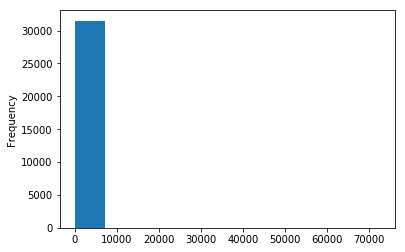

In [61]:
all_posts_df.score.plot.hist(bins=10)

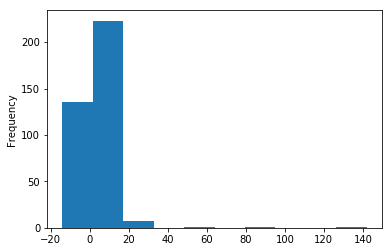

In [56]:
all_comments_df.num_ups.plot.hist(bins=10) # not a great signal

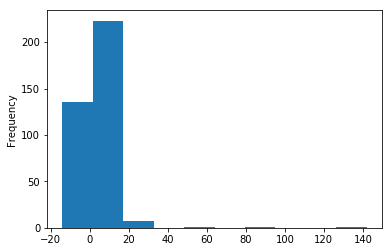

In [62]:
# Score is the same as num_ups
all_comments_df.score.plot.hist(bins=10)

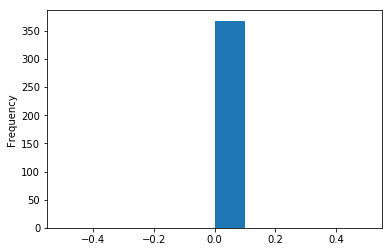

In [59]:
all_comments_df.num_downs.plot.hist(bins=10)

In [64]:
all_comments_df.num_likes#.plot.hist(bins=10)
# Comments don't have upvote ratio available as attribute

0    NaN
0    NaN
0    NaN
1    NaN
2    NaN
    ... 
0    NaN
1    NaN
2    NaN
0    NaN
1    NaN
Name: num_likes, Length: 371, dtype: object

In [82]:
# 63 posts are videos
all_posts_df.is_video.value_counts()

False    31505
True        63
Name: is_video, dtype: int64

## Explore general properties of text

In [67]:
all_comments_df.loc[all_comments_df.text.apply(lambda x: type(x) == float)]

,submission_id,author,text,date,id,controversiality,num_downs,num_ups,num_likes,score,subreddit,parsed_date,year,month
1,[And crock of the week too !](http://climatepr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


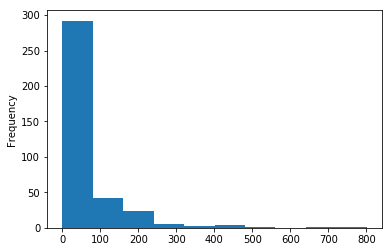

In [71]:
# Length of comments in "words" (split on whitespace)
all_comments_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0).plot.hist()

In [30]:
# Number of posts/comments with <=50 words, per Reid's threshold
all_comments_df['length'] = all_comments_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0)
all_posts_df['text_length'] = all_posts_df.text.apply(lambda x: len(x.split()) if type(x) != float else 0)
all_posts_df['title_length'] = all_posts_df.title.apply(lambda x: len(x.split()) if type(x) != float else 0)
print(all_comments_df.loc[all_comments_df.length.apply(lambda x: x > 0 and x <= 50)].shape,
all_posts_df.loc[all_posts_df.text_length.apply(lambda x: x > 0 and x <= 50)].shape,
     all_posts_df.loc[all_posts_df.title_length.apply(lambda x: x > 0 and x <= 50)].shape)

(261, 15) (2460, 18) (32192, 18)


In [79]:
all_comments_df.text.apply(lambda x: len(x) if type(x) != float else 0).value_counts()

9      16
7       5
58      5
78      4
221     4
       ..
244     1
430     1
192     1
238     1
0       1
Name: text, Length: 263, dtype: int64

In [90]:
# Posts with title content: there are 32.2k (all have titles)
posts_with_titles = all_posts_df.loc[~pd.isnull(all_posts_df.title)]
posts_with_titles.shape

(32301, 15)

In [84]:
# Posts with text content: there are only 6.6k
posts_with_text = all_posts_df.loc[~pd.isnull(all_posts_df.text)]
posts_with_text.shape

(6620, 15)

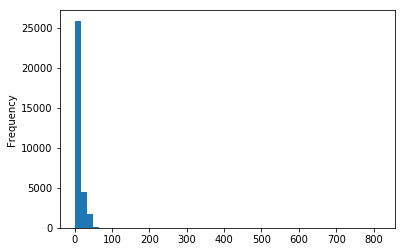

In [91]:
# Length of titles in whitespace-split "words"
posts_with_titles.title.apply(lambda x: len(x.split())).plot.hist(bins=50)

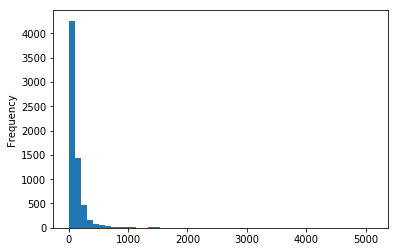

In [86]:
# Length of posts in whitespace-split "words"
posts_with_text.text.apply(lambda x: len(x.split())).plot.hist(bins=50)

In [92]:
# Titles
posts_with_titles.title.apply(lambda x: len(x.split())).value_counts()

9      2565
10     2499
8      2489
11     2386
7      2206
       ... 
73        1
58        1
156       1
61        1
815       1
Name: title, Length: 63, dtype: int64

In [88]:
# A lot of posts have 1 word?
posts_with_text.text.apply(lambda x: len(x.split())).value_counts()

1       144
32       67
38       65
22       63
34       62
       ... 
909       1
945       1
953       1
961       1
1843      1
Name: text, Length: 615, dtype: int64

In [89]:
posts_with_text.loc[posts_with_text.text.apply(lambda x: len(x.split()) == 1)]

,title,author,date,is_video,id,num_downs,num_ups,upvote_ratio,num_comments,score,text,subreddit,parsed_date,year,month
26,Do you agree with -- and/or can you explain wh...,WentzToDJax,1.594729e+09,False,hqulpf,0.0,2.0,0.63,9.0,2.0,https://www.minnpost.com/eric-black-ink/2013/0...,askaconservative,2020-07-14 12:08:34,2020.0,7.0
161,What do you think about bayonets being issued ...,Lavaknight368,1.593848e+09,False,hktcbx,0.0,3.0,1.00,21.0,3.0,https://thehill.com/policy/defense/505717-mill...,askaconservative,2020-07-04 07:32:46,2020.0,7.0
311,How likely is Trump to win (%)?,renaissance_pancakes,1.592994e+09,False,hesd7h,0.0,5.0,0.70,23.0,5.0,Go.,askaconservative,2020-06-24 10:20:14,2020.0,6.0
507,Are there any good conservative historians who...,ActualStreet,1.592009e+09,False,h7o8lv,0.0,6.0,0.88,3.0,6.0,Thanks,askaconservative,2020-06-13 00:42:35,2020.0,6.0
627,What should happen to Kayleigh McEnany if she ...,fizzywater42,1.591473e+09,False,gxpnui,0.0,17.0,0.80,11.0,17.0,https://www.huffpost.com/entry/trump-maralago-...,askaconservative,2020-06-06 19:56:19,2020.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Alex O'Connor (A.K.A. Cosmic Skeptic) is curre...,Omnibeneviolent,1.594266e+09,False,hnntvy,0.0,10.0,0.72,0.0,10.0,https://www.reddit.com/r/vegan/comments/hnmyk0...,skeptic,2020-07-09 03:36:18,2020.0,7.0
167,I love science guys!,AmazingPineaple6,1.593731e+09,False,hjyncq,0.0,0.0,0.10,0.0,0.0,https://encrypted-tbn0.gstatic.com/images?q=tb...,skeptic,2020-07-02 23:04:38,2020.0,7.0
490,Virus man-made according to Norwegian researcher,oli_gendebien,1.591601e+09,False,gyn7bl,0.0,0.0,0.25,9.0,0.0,https://www.forbes.com/sites/davidnikel/2020/0...,skeptic,2020-06-08 07:23:49,2020.0,6.0
1,A new nature economy could generate up to $10....,clim8pablo,1.594849e+09,False,hrnlof,0.0,11.0,1.00,0.0,11.0,[https://www.weforum.org/reports/new-nature-ec...,sustainability,2020-07-15 21:31:58,2020.0,7.0
